<a href="https://colab.research.google.com/github/drug173/Python/blob/main/Neural_Networks/competitions_kaggle_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
keras.preprocessing
from keras.preprocessing import image as image_utils

2.11.0
2.11.0


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [14]:
from zipfile import ZipFile

## Настраиваем Kaggle API

Загружаем токен аутентификации

In [4]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!ls

kaggle.json  sample_data


Копируем токен в каталог .kaggle

In [6]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

## Загружаем данные с сайта Kaggle

In [12]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!ls

digit-recognizer.zip  sample_data


In [15]:
archive = 'digit-recognizer.zip'

In [18]:
with ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

In [19]:
!ls

digit-recognizer.zip  sample_data  sample_submission.csv  test.csv  train.csv


## Проверяем формат данных

Данные для обучения

In [20]:
!head train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

Данные для тестирования

In [21]:
!head test.csv

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pix

Пример файла с решением

In [22]:
!head sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Подготовка данных для обучения сети

Загружаем данные для обучения из файла

In [23]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

In [24]:
train_dataset[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Выделяем данные для обучения

In [25]:
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

Нормализуем данные для обучения

In [26]:
x_train /= 255.0

In [27]:
x_train[1].shape

(28, 28, 1)

Выделяем правильные ответы

In [28]:
y_train = train_dataset[:, 0]

In [29]:
y_train[:5]

array([1., 0., 1., 4., 0.])

Преобразуем ответы в формат one hot encoding

In [30]:
y_train = utils.to_categorical(y_train)

In [31]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Разделяем набор данных на две части: для обучения (X_Train, Y_train) и проверки (X_val, Y_val)

In [32]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [33]:
X_train.shape

(37800, 28, 28, 1)

Создаем генератор для расширения данных

In [34]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

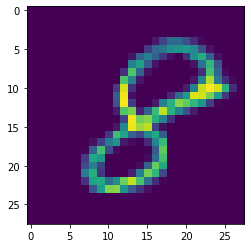

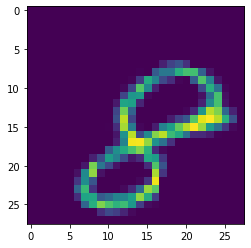

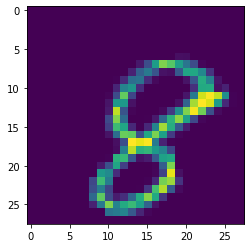

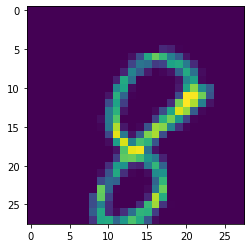

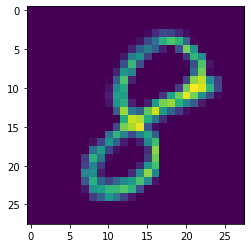

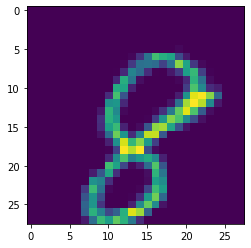

In [35]:
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Создаем нейронную сеть

**Создаем последовательную модель**

In [36]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

**Компилируем сеть**

In [37]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

## Обучаем нейронную сеть

In [59]:
сheckpoint = ModelCheckpoint('mnist-cnn.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

In [60]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [61]:
batch_size=96

In [62]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
393/393 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9902
Epoch 1: val_accuracy improved from -inf to 0.99405, saving model to mnist-cnn.h5
393/393 [==============================] - 15s 38ms/step - loss: 0.0295 - accuracy: 0.9902 - val_loss: 0.0198 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 2/30
393/393 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9915
Epoch 2: val_accuracy improved from 0.99405 to 0.99500, saving model to mnist-cnn.h5
393/393 [==============================] - 15s 37ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0225 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 3/30
392/393 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9911
Epoch 3: val_accuracy did not improve from 0.99500
393/393 [==============================] - 14s 37ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0196 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 4/30
393/393 [==============================] - ET

In [68]:
!ls
import os
print(os.getcwd())

digit-recognizer.zip  sample_data	     submission.csv  train.csv
mnist-cnn.h5	      sample_submission.csv  test.csv
/content


In [86]:
model.load_weights('mnist-cnn.h5')

## Визуализация качества обучения


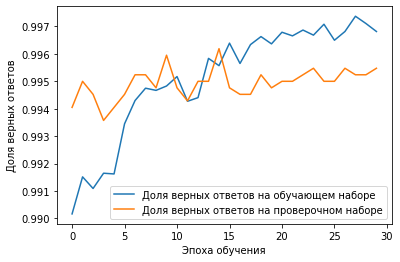

In [73]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем данные для распознавания

In [74]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [75]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

Нормализация данных

In [77]:
x_test = x_test / 255.0

## Запускаем распознавание рукописных цифр из тестового набора данных

In [78]:
predictions = model.predict(x_test)

875/875 [==============================] - 3s 3ms/step


In [79]:
predictions[:5]

array([[4.14008614e-20, 1.68241648e-19, 1.00000000e+00, 8.18259902e-13,
        1.22214695e-19, 1.28080816e-20, 6.53942870e-22, 2.26667414e-15,
        2.71312937e-14, 2.43295180e-18],
       [1.00000000e+00, 5.50473372e-15, 1.07148422e-10, 1.20096804e-12,
        4.13524943e-12, 1.06909162e-10, 1.35206757e-09, 1.61376364e-11,
        9.03866565e-11, 3.09509085e-09],
       [1.22154800e-10, 1.49318197e-10, 2.48312588e-08, 1.50450141e-08,
        1.94768472e-06, 3.22515764e-11, 2.31348224e-15, 7.40591988e-09,
        6.31541980e-07, 9.99997377e-01],
       [9.99740303e-01, 4.74117412e-09, 6.29894430e-06, 3.91269987e-06,
        1.69977845e-08, 1.44399492e-05, 4.70494706e-05, 2.63760029e-07,
        6.90932357e-05, 1.18574193e-04],
       [4.00860651e-21, 8.80779214e-14, 2.08670407e-12, 1.00000000e+00,
        1.87719875e-21, 1.61432011e-12, 4.02864917e-18, 9.35794411e-14,
        9.49586069e-12, 4.38403959e-14]], dtype=float32)

Преобразуем результаты распознавания из формата one hot encoding в цифры

In [80]:
predictions = np.argmax(predictions, axis=1)

In [81]:
predictions[:5]

array([2, 0, 9, 0, 3])

## Готовим файл с решением для Kaggle

In [82]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [84]:
out[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

Записываем результаты в файл 

In [56]:
np.savetxt('submission.csv', out, header="ImageId,Label", 
            comments="", fmt="%d,%d")

In [85]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


## Отправляем решение на соревнование

In [58]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:01<00:00, 121kB/s]
Successfully submitted to Digit Recognizer